I have been interested in looking at MLB pitch data for a while now, however, I have not found any good blob posts or tutorials for doing this. So during the MLB Playoffs, while I was checking the score of Cubs vs. Dodgers, Game 5 on Yahoo! it struck me that there is proabably a way to get the live game data from Yahoo! while the game is in progress.  So I poked arond and found that there is! In this post, I will review what I found and how to use the data to make pitch charts using the data from World Series Game 7.

In [1]:
import requests

In [2]:
game_id = '361102105'#361101105'#361020119'

In [3]:
game_url = 'https://api-secure.sports.yahoo.com/v1/editorial/s/boxscore/mlb.g.' + game_id + '?lang=en-US&region=US&tz=America%2FChicago&ysp_redesign=1&mode=&v=4&ysp_enable_last_update=1&polling=1'

In [4]:
headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10.10; rv:39.0) Gecko/20100101 Firefox/39.0'}
response = requests.get(game_url, headers=headers)
game_data = response.json()

In [5]:
pitches = game_data['service']['boxscore']['gamepitches']['mlb.g.'+game_id]

In [6]:
print("Total number of pitches thrown during the game: " + str(len(pitches)))

Total number of pitches thrown during the game: 343


In [7]:
import pandas as pd

In [8]:
pitch_df = pd.DataFrame(pitches)

need to change data types first

In [9]:
transpose_pitch_df = pitch_df.transpose()

In [10]:
for val in list(transpose_pitch_df.columns.values):
    transpose_pitch_df[val] = transpose_pitch_df[val].convert_objects(convert_numeric=True)

C:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\lib\site-packages\ipykernel\__main__.py:2: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  from ipykernel import kernelapp as app


In [11]:
transpose_pitch_df.dtypes

balls           int64
batter          int64
game            int64
horizontal    float64
period          int64
pitch_num       int64
pitch_type    float64
pitcher         int64
play_num        int64
play_type      object
result          int64
sequence        int64
strikes         int64
velocity      float64
vertical      float64
dtype: object

In [12]:
from bs4 import BeautifulSoup

In [13]:
pitcher_url = 'http://sports.yahoo.com/mlb/players/' + str(transpose_pitch_df['pitcher']['10100']) + '/'
req = requests.get(pitcher_url)
html = req.text
soup = BeautifulSoup(html, 'html.parser')
print("On the mound to start the game: " + soup.title.string)
batter_url = 'http://sports.yahoo.com/mlb/players/' + str(transpose_pitch_df['batter']['10100']) + '/'
req = requests.get(batter_url)
html = req.text
soup = BeautifulSoup(html, 'html.parser')
print("First batter faced: " + soup.title.string)

On the mound to start the game: Corey Kluber | Cleveland | Major League Baseball | Yahoo! Sports
First batter faced: Dexter Fowler | Chi Cubs | Major League Baseball | Yahoo! Sports


In [14]:
pitcher_list = transpose_pitch_df.pitcher.unique()
for pitcher in pitcher_list:
    pitcher_url = 'http://sports.yahoo.com/mlb/players/' + str(pitcher) + '/'
    req = requests.get(pitcher_url)
    html = req.text
    soup = BeautifulSoup(html, 'html.parser')
    pitcher_info = soup.title.string
    print(pitcher_info.split('|')[0] + " of the " + pitcher_info.split('|')[1] + "(Yahoo ID: "+str(pitcher)+")")

Andrew Miller  of the  Cleveland (Yahoo ID: 7847)
Corey Kluber  of the  Cleveland (Yahoo ID: 9048)
Kyle Hendricks  of the  Chi Cubs (Yahoo ID: 9758)
Jon Lester  of the  Chi Cubs (Yahoo ID: 7790)
Cody Allen  of the  Cleveland (Yahoo ID: 9243)
Aroldis Chapman  of the  Chi Cubs (Yahoo ID: 8616)
Bryan Shaw  of the  Cleveland (Yahoo ID: 8962)
Trevor Bauer  of the  Cleveland (Yahoo ID: 9122)
Carl Edwards Jr.  of the  Chi Cubs (Yahoo ID: 9555)
Mike Montgomery  of the  Chi Cubs (Yahoo ID: 8684)


In [15]:
transpose_pitch_df.head()

,balls,batter,game,horizontal,period,pitch_num,pitch_type,pitcher,play_num,play_type,result,sequence,strikes,velocity,vertical
10010100,0,9604,361102105,11667,10,1,3,7847,10010100,PITCH,0,1,0,82,3333
10010200,1,9604,361102105,-5000,10,2,3,7847,10010200,PITCH,1,2,0,81,-3333
10010300,1,9604,361102105,-8333,10,3,1,7847,10010300,PITCH,2,3,1,91,13333
10010400,1,9604,361102105,16667,10,4,3,7847,10010400,PITCH,0,4,2,83,-13333
10010500,2,9604,361102105,-1667,10,5,3,7847,10010500,PITCH,3,5,2,82,-6667


In [16]:
kluber = transpose_pitch_df[transpose_pitch_df.pitcher == 9048]
hendricks = transpose_pitch_df[transpose_pitch_df.pitcher == 9758]

In [17]:
import matplotlib.pyplot as plt

In [18]:
%matplotlib inline

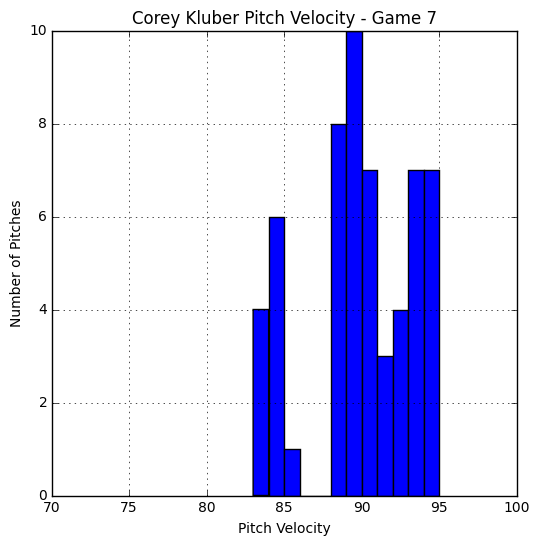

In [19]:
plt.figure(figsize=(6,6))
plt.subplot(111)
k_max = kluber.velocity.max()
k_min = kluber.velocity.min()
ax1= kluber['velocity'].hist(bins=k_max-k_min)
plt.xlim(70, 100)
plt.title('Corey Kluber Pitch Velocity - Game 7')
plt.xlabel('Pitch Velocity')
plt.ylabel('Number of Pitches')

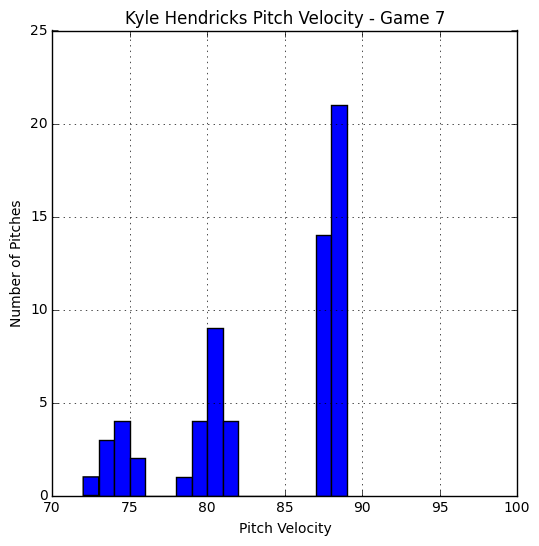

In [20]:
plt.figure(figsize=(6,6))
plt.subplot(111)
h_max = hendricks.velocity.max()
h_min = hendricks.velocity.min()
ax2 = hendricks['velocity'].hist(bins=h_max-h_min)
plt.xlim(70, 100)
plt.title('Kyle Hendricks Pitch Velocity - Game 7')
plt.xlabel('Pitch Velocity')
plt.ylabel('Number of Pitches')

Next, I want to look at Yahoo!'s pitch location. 

In [21]:
sorted_kluber_pitches = kluber.sort_values(['play_num'])
sorted_hendricks_pitches = hendricks.sort_values(['play_num'])
kluber_balls =sorted_kluber_pitches[sorted_kluber_pitches.result == 0]
hendricks_balls =sorted_hendricks_pitches[sorted_hendricks_pitches.result == 0]
kluber_others =sorted_kluber_pitches[sorted_kluber_pitches.result != 0]
hendricks_others =sorted_hendricks_pitches[sorted_hendricks_pitches.result != 0]

In [22]:
import seaborn as sns

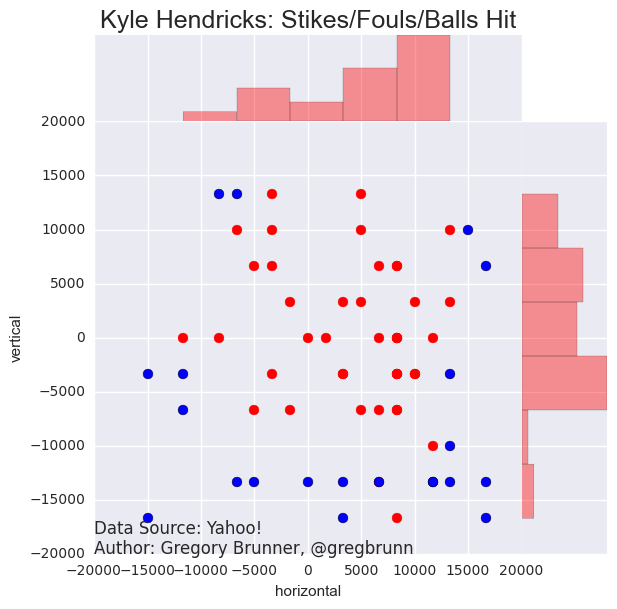

In [23]:
# create our jointplot
joint_chart = sns.jointplot(hendricks_others.horizontal,
                                 hendricks_others.vertical, 
                                 stat_func=None,
                                 color='r',
                                 marker='o',
                                 s=50,
                                 kind='scatter', 
                                 space=0, 
                                 alpha=1.0)

joint_chart.fig.set_size_inches(6,6)

joint_chart.x = hendricks_balls.horizontal
joint_chart.y = hendricks_balls.vertical
joint_chart.plot_joint(plt.scatter, marker='o', c='b', s=50)

# A joint plot has 3 Axes, the first one called ax_joint 
# is the one we want to draw our court onto and adjust some other settings
ax = joint_chart.ax_joint

# Adjust the axis limits and orientation of the plot in order
# to plot half court, with the hoop by the top of the plot
ax.set_xlim(-20000,20000)
ax.set_ylim(-20000, 20000)

# Get rid of axis labels and tick marks
#ax.set_xlabel('')
#ax.set_ylabel('')
#ax.tick_params(labelbottom='off', labelleft='off')

# Add a title
ax.set_title('Kyle Hendricks: Stikes/Fouls/Balls Hit', 
             y=1.2, fontsize=18)

# Add Data Scource and Author
ax.text(-20000,-20000,'Data Source: Yahoo!'
        '\nAuthor: Gregory Brunner, @gregbrunn',
        fontsize=12)

plt.show()

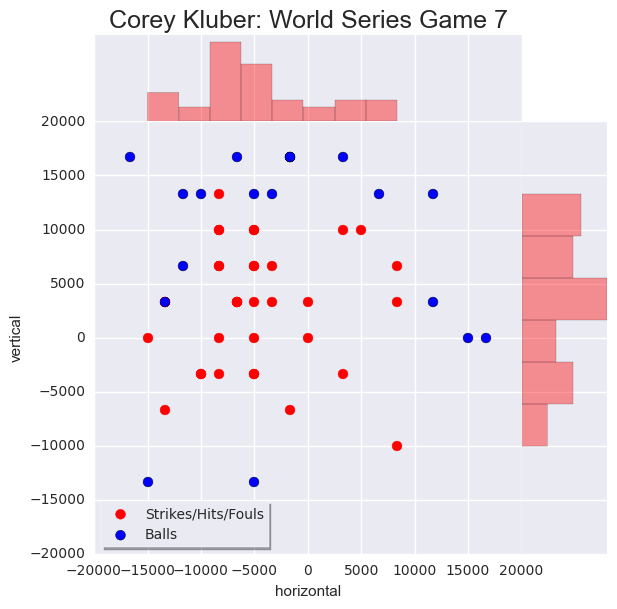

In [42]:
joint_chart = sns.jointplot(kluber_others.horizontal,
                                 kluber_others.vertical, 
                                 stat_func=None,
                                 color='r',
                                 marker='o',
                                 s=50,
                                 kind='scatter', 
                                 space=0, 
                                 label='Strikes/Hits/Fouls',
                                 alpha=1.0)

joint_chart.fig.set_size_inches(6,6)

joint_chart.x = kluber_balls.horizontal
joint_chart.y = kluber_balls.vertical
joint_chart.plot_joint(plt.scatter, marker='o', c='b', s=50,label='Balls')

# A joint plot has 3 Axes, the first one called ax_joint 
# is the one we want to draw our court onto and adjust some other settings
ax = joint_chart.ax_joint

# Adjust the axis limits and orientation of the plot in order
# to plot half court, with the hoop by the top of the plot
ax.set_xlim(-20000,20000)
ax.set_ylim(-20000, 20000)

# Get rid of axis labels and tick marks
#ax.set_xlabel('')
#ax.set_ylabel('')
#ax.tick_params(labelbottom='off', labelleft='off')

# Add a title
ax.set_title('Corey Kluber: World Series Game 7', 
             y=1.2, fontsize=18)
ax.legend(loc=3, frameon=True, shadow=True)


# Add Data Scource and Author
#ax.text(-20000,-20000,'Data Source: Yahoo!'
#        '\nAuthor: Gregory Brunner, @gregbrunn',
#        fontsize=12)

plt.show()

In [43]:
play_by_play = game_data['service']['boxscore']['gameplay_by_play']['mlb.g.'+game_id]